In [14]:
import pandas as pd
import pyhf 
import numpy as np
import matplotlib.pyplot as plt

In [15]:
MC = pd.read_csv('dataframe.csv')
data = pd.read_csv('Output_ZPrimeBoostedAnalysis/data.csv', delimiter=' ')

In [16]:
sig = MC.loc[MC['label'] == 1]
bkg = MC.loc[MC['label'] == 0]
sig

,Unnamed: 0,ID,etmiss,mtw,leadleptPt,leadleptEta,leadleptE,leadleptPhi,Q_leadlep,leadleptID,...,ttbarMLR,largeRjet_pt_total,largeRjet_eta_total,largeRjet_phi_total,largeRjet_m_total,largeRjet_tau32_total,weight,scale,label,scaleweight
0,0,signal,284.0070,51.4513,158.2950,0.125750,159.5480,0.246570,-1,13,...,616.923,434.907,0.003795,-3.105850,172.235,0.263504,0.000000,0.056722,1,0.000000
1,1,signal,194.7950,100.9790,58.2204,-0.676782,72.0706,-0.338934,1,11,...,571.721,373.238,0.031308,-2.606120,158.346,0.462140,0.000000,0.056722,1,0.000000
2,2,signal,248.7820,68.8350,44.5272,-0.311100,46.6994,3.066820,-1,11,...,536.674,403.840,0.685499,0.631162,175.933,0.290648,0.000000,0.056722,1,0.000000
3,3,signal,98.7296,19.8922,261.8510,0.385745,281.5750,-2.184720,1,13,...,921.435,472.371,0.048611,0.576137,223.665,0.428973,0.000000,0.056722,1,0.000000
4,4,signal,248.7050,32.9140,149.7410,1.617440,392.2160,-1.361590,1,11,...,853.772,420.366,0.136872,1.328520,121.342,0.496269,0.002304,0.056722,1,0.000131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8370,8370,signal,24.2499,104.0960,111.7440,-1.956930,403.3330,-1.723010,1,13,...,932.043,336.291,-0.433947,1.473410,105.334,0.609317,1.329410,0.056722,1,0.075407
8371,8371,signal,95.1878,24.6720,179.7690,-0.444874,197.8540,0.881862,-1,11,...,865.601,731.367,-1.672080,-0.796972,293.637,1.141300,0.598800,0.056722,1,0.033965
8372,8372,signal,153.1980,63.4906,187.6550,1.723680,542.6550,1.001110,-1,11,...,0.000,365.843,1.817990,-1.634620,164.973,0.358114,1.180120,0.056722,1,0.066939
8373,8373,signal,66.7495,96.2545,135.1560,0.897734,193.3770,0.352789,-1,11,...,880.486,753.805,2.187680,-1.931020,289.333,1.138280,1.151360,0.056722,1,0.065308


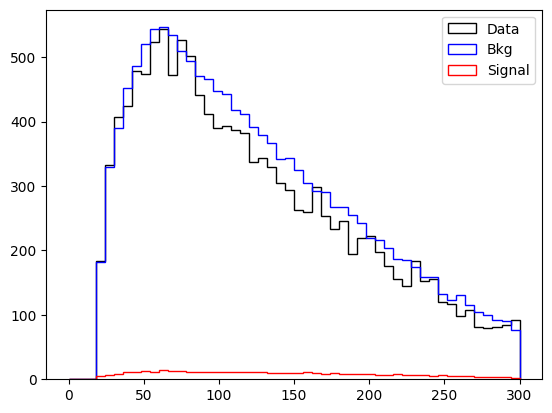

In [23]:
N, bins = np.histogram(data['etmiss'], bins=50, range=(0, 300), weights=data["weight"])
B = np.histogram(bkg['etmiss'], bins=bins, weights=bkg['scaleweight'])[0]
S = np.histogram(sig['etmiss'], bins=bins, weights=sig['scaleweight'])[0]

bin = plt.hist(data['etmiss'], bins=50, weights=data["weight"], range=(0, 300), histtype='step', color='black', label='Data')
plt.hist(bkg['etmiss'], bins=bin[1], weights=bkg['scaleweight'], histtype='step', color='blue', label='Bkg')
plt.hist(sig['etmiss'], bins=bin[1], weights=sig['scaleweight'], histtype='step', color='red', label='Signal')
plt.legend()
plt.show()


In [24]:
model_spec = {'channels': [{'name': 'singlechannel',
              'samples': [
              {'name': 'signal','data': S.tolist(),
               'modifiers': [{'data': None, 'name': 'mu', 'type': 'normfactor'}]},
              {'name': 'bkg1','data': B.tolist(),
               'modifiers': []},
              ]
              }],
              "observations": [{ "name": "singlechannel", "data": N.tolist() }],
              "measurements": [{ "name": "Measurement", "config": {"poi": "mu", "parameters": []}}],
              "version": "1.0.0",
}

workspace = pyhf.Workspace(model_spec)
model = workspace.model()

print("## Model")
print(f"  channels: {model.config.channels}")
print(f"     nbins: {model.config.channel_nbins}")
print(f"   samples: {model.config.samples}")
print(f" modifiers: {model.config.modifiers}")
print(f"parameters: {model.config.parameters}")
print(f"par. order: {model.config.par_order}")

print("\n## Model parameters")
print(f'   default: {model.config.suggested_init()}')
print(f'    bounds: {model.config.suggested_bounds()}')

data = N.tolist() + model.config.auxdata

test_stat = "qtilde"
test_poi = 1.

# Vary mu values
poi_values = np.linspace(0.01, 5, 500)
obs_limit, exp_limits, scan = pyhf.infer.intervals.upper_limits.upper_limit(data, model, poi_values, level=0.05, return_results=True)
print(f"\nObserved μ upper limit (obs): {obs_limit:.3f}, Expected μ upper limit {exp_limits[2]:.3f}")

CLs_obs, CLs_exp = pyhf.infer.hypotest(test_poi, data, model, test_stat=test_stat, return_expected=True)
print(f"Observed CL_s: {CLs_obs}, Expected CL_s: {CLs_exp} ")

## Model
  channels: ['singlechannel']
     nbins: {'singlechannel': 50}
   samples: ['bkg1', 'signal']
 modifiers: [('mu', 'normfactor')]
parameters: ['mu']
par. order: ['mu']

## Model parameters
   default: [1.0]
    bounds: [(0, 10)]

Observed μ upper limit (obs): 0.089, Expected μ upper limit 0.572
Observed CL_s: 2.1218792896902282e-17, Expected CL_s: 0.0006434034811375227 


### Dúvidas
- valores dos mu fazem sentido?
- likelihood sem NN
- questão da sensibilidade
- interpretação
- 3 modelos